In [214]:
#import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

from scipy import sparse
import scipy.stats as st
from scipy.stats import skew

from build_features import preprocess_features, process_features, remove_outliers


In [215]:
#read in data
housing = pd.read_csv('../data/train.csv')
# Log transform the target for official scoring
housing.SalePrice = np.log(housing.SalePrice)

In [216]:
#Split data for train and validation set
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=21)
for train_ix, test_ix in split.split(housing, housing['MSZoning']):
    df_train = housing.loc[train_ix]
    df_test = housing.loc[test_ix]

In [217]:
#select columns for modeling based on exploritory analysis

num_model = ['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF','GrLivArea'
                , 'LotFrontage', 'LotArea','MasVnrArea', 'WoodDeckSF'
                , 'OpenPorchSF','OverallQual', 'TotRmsAbvGrd', 'ExterQual'
                , 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'
                , 'HeatingQC',  'Fireplaces', 'FireplaceQu','GarageFinish'
                , 'GarageQual', 'LotShape', 'KitchenQual','Functional']

    
cat_model = ['MSSubClass','MSZoning', 'Street', 'LandContour','LotConfig'
                    , 'Neighborhood', 'BldgType', 'HouseStyle','RoofStyle', 'MasVnrType'
                    , 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'PavedDrive'
                    ,  'MoSold', 'YrSold', 'SaleType', 'SaleCondition' 
                    , 'Exterior1st','Exterior2nd','Alley','GarageType','Fence']



special_model = ['Utilities','Condition1', 'Condition2', 'RoofMatl'
                 , 'LowQualFinSF', 'GarageArea','GarageCars'
                ,'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

added_cols = []

In [218]:
#Run all processing steps
df_train_tr = df_train.copy()
df_test_tr = df_test.copy()

In [219]:
#Remove outliers and reformat text features
added_cols = []
df_train_tr = remove_outliers(df_train_tr)
df_train_tr, num, add = preprocess_features(df_train_tr, num_model, added_cols, combine_garage=True)

In [220]:
#Save column names for all features
final_num = num.copy()
final_cat = cat_model.copy()
final_added = add.copy()

In [221]:
df_test_tr = remove_outliers(df_test_tr)
df_test_tr, _, _ = preprocess_features(df_test_tr, num_model, added_cols, combine_garage=True)

In [222]:
#Save sale price for predictions
df_train_tr_label = df_train_tr.pop('SalePrice')
df_test_tr_label = df_test_tr.pop('SalePrice')

In [223]:
#Impute, log transform (based on skew) and scale data
final_df, final_test_df = process_features(df_train_tr, df_test_tr, final_num,
                            final_cat, final_added, drop=True, add_poly=True)

61 skewed numerical features to log transform


In [224]:
def add_missing_dummy_columns(d, columns ):
    #Some categories were missing in test set- add colums as zeros
    missing_cols = set( columns ) - set( d.columns )
    for c in missing_cols:
        d[c] = 0

In [225]:
def fix_columns( d, columns ):  
    
    #Add missing columns and check if there are any extra in the test set
    add_missing_dummy_columns( d, columns )

    # make sure we have all the columns we need
    assert( set( columns ) - set( d.columns ) == set())

    extra_cols = set( d.columns ) - set( columns )
    if extra_cols:
        print("extra columns:", extra_cols)

    d = d[ columns ]
    return d

In [226]:
#add missing columns to test set
fixed_test = fix_columns(final_test_df.copy(), final_df.columns.values.tolist() )

In [227]:
final_df_label = df_train_tr_label.reset_index(drop=True).copy()
final_test_df_label = df_test_tr_label.reset_index(drop=True).copy()

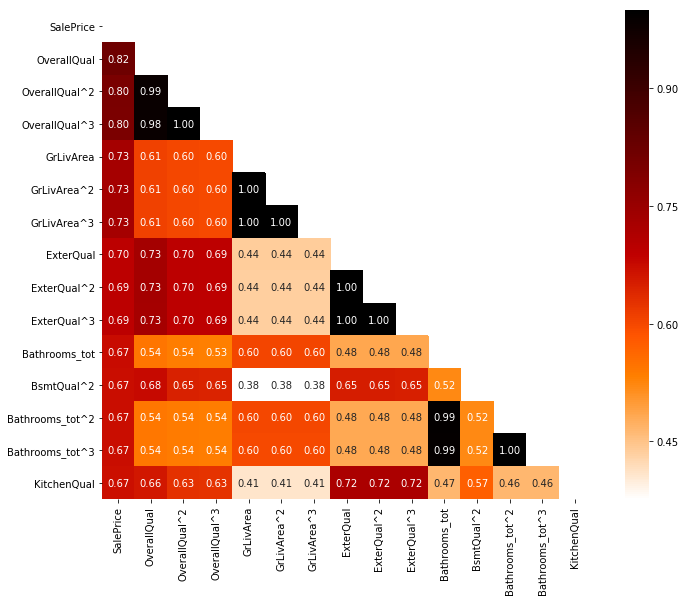

In [228]:
#saleprice correlation matrix with final data frame after processing
temp = final_df.copy()
temp['SalePrice'] = final_df_label.copy()
corr = temp.corr()

cols = corr.nlargest(15, 'SalePrice').index

cm = np.corrcoef(temp[cols].values.T)

mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
                 xticklabels=cols.values, cmap='gist_heat_r', mask=mask)
plt.show()

In [229]:
#for testing if subsets make a noticable difference in rmse

best = corr.nlargest(234, 'SalePrice').index.tolist()
best.remove("SalePrice")
X_train = final_df[best].copy()
X_test = fixed_test[best].copy()



y_train = final_df_label.copy()
y_test = final_test_df_label.copy()

In [230]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [231]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [232]:
preds = lin_reg.predict(X_train)

print("RMSE on Training set :", rmse_cv_train(lin_reg).mean())
print("RMSE on Test set :", rmse_cv_test(lin_reg).mean())



RMSE on Training set : 16.1117228238159
RMSE on Test set : 124.03693182490095


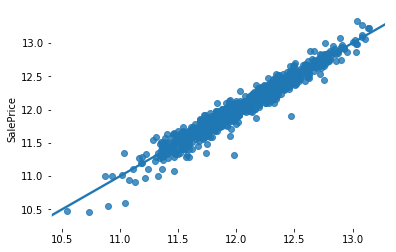

In [233]:
sns.regplot( preds,y_train)

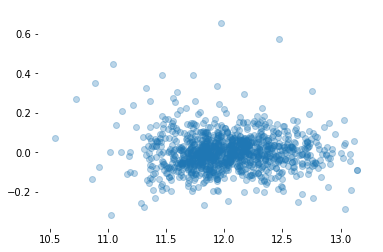

In [234]:
plt.scatter(preds, preds - y_train, marker = "o", label = "Training data", alpha = 0.3)

In [235]:
preds_test = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, preds_test)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.2527368793637187

In [236]:
tree_reg = DecisionTreeRegressor()

In [237]:
tree_reg.fit(X_train, y_train)
hous_preds = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, hous_preds)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

2.9205527498267372e-05

In [238]:
print("RMSE on Training set :", rmse_cv_train(tree_reg).mean())
print("RMSE on Test set :", rmse_cv_test(tree_reg).mean())

RMSE on Training set : 0.21582955016239805
RMSE on Test set : 0.21020715567150394


In [239]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

forest_preds = forest_reg.predict(X_train)
forest_preds_test = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_train, forest_preds)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.06362109829681807

In [240]:
print("RMSE on Training set :", rmse_cv_train(forest_reg).mean())
print("RMSE on Test set :", rmse_cv_test(forest_reg).mean())

RMSE on Training set : 0.15363446873757636
RMSE on Test set : 0.1649614462556321


In [241]:
def makeplot(train, test, y_tr, y_te, save='plot'):
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'white'
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.color'] = "#cccccc"
    plt.grid(True)
    plt.scatter(train, y_tr, marker = 'o', label = "Training data", alpha=0.3)
    plt.scatter(test,y_te, c = "tab:green", marker = "o", label = "Validation data", alpha=0.4)
    plt.legend(loc='lower right')
    plt.xlabel('Predictions')
    plt.ylabel("Labels")
    plt.savefig(save+'.png')

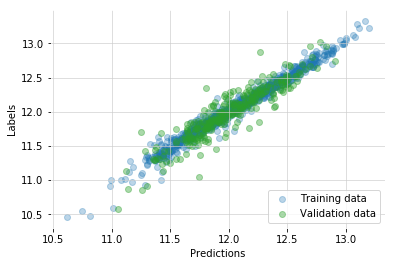

In [242]:
makeplot(forest_preds, forest_preds_test, y_train, y_test)

In [243]:
lasso = Lasso(alpha=0.0007, max_iter = 10000)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_train)
lasso_preds_test = lasso.predict(X_test)
print("RMSE on Training set :", rmse_cv_train(lasso).mean())
print("RMSE on Test set :", rmse_cv_test(lasso).mean())

RMSE on Training set : 0.12234955920313306
RMSE on Test set : 0.11983876759479847


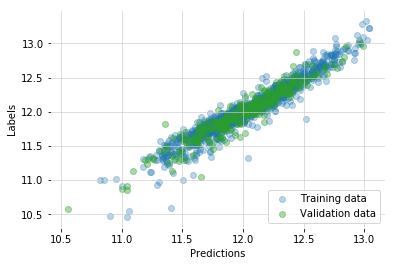

In [244]:
makeplot(lasso_preds, lasso_preds_test, y_train, y_test, save='lasso')

In [265]:
ridge_1 = Ridge()
params = {  
    "alpha": st.uniform(0.001, 40),
}
ridge_op = RandomizedSearchCV(ridge_1, params, n_jobs=1)  
ridge_op.fit(X_train, y_train)  
ridge_op.best_params_ 

{'alpha': 6.176583988622173}

In [266]:
ridge = Ridge(alpha = 6.17658398)
ridge.fit(X_train, y_train)  
ridge_preds = ridge.predict(X_train)
ridge_preds_test = ridge.predict(X_test)
print("RMSE on Training set :", rmse_cv_train(ridge).mean())
print("RMSE on Test set :", rmse_cv_test(ridge).mean())

RMSE on Training set : 0.1197193880969657
RMSE on Test set : 0.11616294686551139


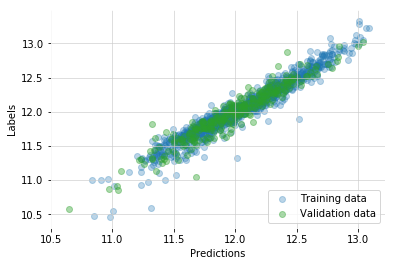

In [267]:
makeplot(ridge_preds, ridge_preds_test, y_train, y_test,save='ridge')

In [268]:
enet = ElasticNet(l1_ratio=0.1)
enet.fit(X_train, y_train)
enet_preds = enet.predict(X_train)
enet_preds_test = enet.predict(X_test)
print("RMSE on Training set :", rmse_cv_train(enet).mean())
print("RMSE on Test set :", rmse_cv_test(enet).mean())

RMSE on Training set : 0.2212535892158301
RMSE on Test set : 0.21017310390688615


Ridge picked 233 features and eliminated the other 0 features


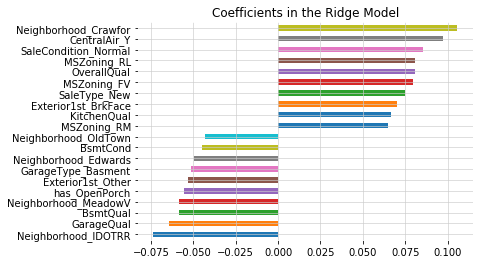

In [269]:
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.grid(True)
plt.savefig('ridge_coef.png')
plt.show()

Lasso picked 82 features and eliminated the other 151 features


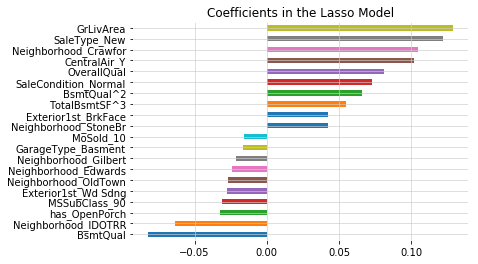

In [270]:
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.grid(True)
plt.savefig('lasso_coef.png')
plt.show()

In [271]:
xg_train = xgb.DMatrix(X_train, label = y_train)
xg_test = xgb.DMatrix(X_test, label = y_test)

params = {"max_depth":2, "eta":0.05, "n_estimators": 230}
model = xgb.cv(params, xg_train,  num_boost_round=500, early_stopping_rounds=100)

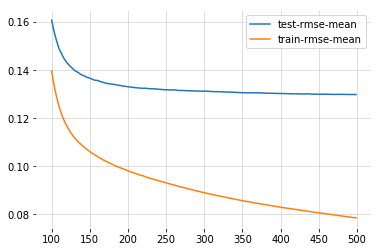

In [272]:
model.loc[100:,["test-rmse-mean", "train-rmse-mean"]].plot(grid=True)

In [273]:
xgb = XGBRegressor(learning_rate= 0.05, max_depth= 2, n_estimators= 150) 

In [274]:
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_train)
xgb_preds_test = xgb.predict(X_test)
print("RMSE on Training set :", rmse_cv_train(xgb).mean())
print("RMSE on Test set :", rmse_cv_test(xgb).mean())

RMSE on Training set : 0.13429360946040408
RMSE on Test set : 0.1482623086865114


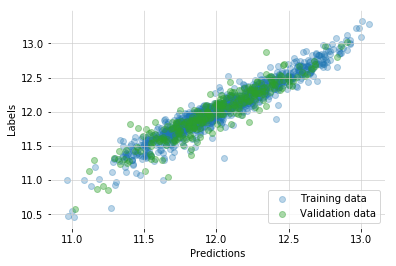

In [275]:
makeplot(xgb_preds, xgb_preds_test, y_train, y_test)

In [276]:
#Simple weighted average
comb_preds = .25*xgb_preds+.25*ridge_preds+.25*lasso_preds+.25*forest_preds
comb_preds_test = .25*xgb_preds_test+.25*ridge_preds_test+.25*lasso_preds_test+.25*forest_preds_test

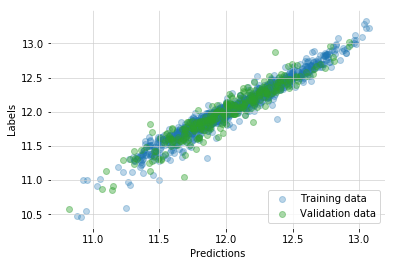

In [277]:
makeplot(comb_preds, comb_preds_test, y_train, y_test)

In [278]:
#Improves rmse for train
comb_mse = mean_squared_error(y_train, comb_preds)
comb_rmse = np.sqrt(comb_mse)
comb_rmse

0.08813165500068437

In [279]:
#Not really reduced for test
comb_mse = mean_squared_error(y_test, comb_preds_test)
comb_rmse = np.sqrt(comb_mse)
comb_rmse

0.12026638818691635

In [280]:
#Optimize xgb
params = {  
    "n_estimators": st.randint(3, 300),
    "max_depth": st.randint(2, 20),
    "learning_rate": st.uniform(0.03, 0.5),

}
gs = RandomizedSearchCV(xgb, params, n_jobs=1)  
gs.fit(X_train, y_train)  
gs.best_params_ 

{'learning_rate': 0.05467447339421985, 'max_depth': 7, 'n_estimators': 135}

In [281]:
gs_preds = gs.predict(X_train)
gs_preds_test = gs.predict(X_test)
gs_mse = mean_squared_error(y_train, gs_preds)
gs_rmse = np.sqrt(gs_mse)
gs_rmse

0.046664690863948775

In [282]:
#Still a high rmse for test
gs_mse_t = mean_squared_error(y_test, gs_preds_test)
gs_rmse_t = np.sqrt(gs_mse_t)
gs_rmse_t

0.1327618507630354

In [283]:
#make a simple stack using the previous models

pred_df = pd.DataFrame({'xgb_preds':xgb_preds, 'ridge_preds': ridge_preds,'lasso_preds': lasso_preds,
                      'gs_preds':gs_preds})
pred_df_test = pd.DataFrame({'xgb_preds':xgb_preds_test, 'ridge_preds': ridge_preds_test,
                             'lasso_preds': lasso_preds_test, 'gs_preds':gs_preds_test})

In [284]:
#copy dataframe for convenience

X_train_p = pred_df.copy()
X_test_p = pred_df_test.copy()

In [285]:
X_train_p.head()

,xgb_preds,ridge_preds,lasso_preds,gs_preds
0,11.835438,11.837543,11.850269,11.832512
1,11.855693,11.929180,11.942599,11.811048
2,11.659963,11.698591,11.685032,11.742012
3,12.016960,12.208805,12.171648,12.076178
4,12.077724,12.166616,12.149075,12.091212


In [286]:
#train ridge model on predicted values
ridge_2 = Ridge()
params = {  
    "alpha": st.uniform(0.001, 40),
}
ridge_p2 = RandomizedSearchCV(ridge_2, params, n_jobs=1)  
ridge_p2.fit(X_train_p, y_train)  
ridge_p2.best_params_ 

{'alpha': 0.2071185707609292}

In [287]:
#Fit models on predicted values

lin_reg_p = LinearRegression()
lin_reg_p.fit(X_train_p, y_train)

ridge_p = Ridge(0.207)
ridge_p.fit(X_train_p, y_train)

tree_p = RandomForestRegressor()
tree_p.fit(X_train_p, y_train)

lasso_p = Lasso(alpha=0.0005)
lasso_p.fit(X_train_p, y_train)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [288]:
stack_preds = lin_reg_p.predict(X_train_p)
stack_preds_test = lin_reg_p.predict(X_test_p)

rmse_tr= np.sqrt(-cross_val_score(lin_reg_p, X_train_p, y_train, scoring = scorer, cv = 10))
rmse_te= np.sqrt(-cross_val_score(lin_reg_p, X_test_p, y_test, scoring = scorer, cv = 10))

print("RMSE on Training set :", rmse_tr.mean())
print("RMSE on Test set :", rmse_te.mean())

RMSE on Training set : 0.03674577407512543
RMSE on Test set : 0.1127331288967752


In [289]:
ridge_stack_preds = ridge_p.predict(X_train_p)
ridge_stack_preds_test = ridge_p.predict(X_test_p)

rmse_tr= np.sqrt(-cross_val_score(ridge_p, X_train_p, y_train, scoring = scorer, cv = 10))
rmse_te= np.sqrt(-cross_val_score(ridge_p, X_test_p, y_test, scoring = scorer, cv = 10))

print("RMSE on Training set :", rmse_tr.mean())
print("RMSE on Test set :", rmse_te.mean())

RMSE on Training set : 0.03693292363543346
RMSE on Test set : 0.11184605146082209


In [290]:
tree_stack_preds = tree_p.predict(X_train_p)
tree_stack_preds_test = tree_p.predict(X_test_p)

rmse_tr= np.sqrt(-cross_val_score(tree_p, X_train_p, y_train, scoring = scorer, cv = 10))
rmse_te= np.sqrt(-cross_val_score(tree_p, X_test_p, y_test, scoring = scorer, cv = 10))

print("RMSE on Training set :", rmse_tr.mean())
print("RMSE on Test set :", rmse_te.mean())

RMSE on Training set : 0.043748551202769395
RMSE on Test set : 0.12984045442805545


In [291]:
lasso_stack_preds = lasso_p.predict(X_train_p)
lasso_stack_preds_test = lasso_p.predict(X_test_p)

rmse_tr= np.sqrt(-cross_val_score(lasso_p, X_train_p, y_train, scoring = scorer, cv = 10))
rmse_te= np.sqrt(-cross_val_score(lasso_p, X_test_p, y_test, scoring = scorer, cv = 10))

print("RMSE on Training set :", rmse_tr.mean())
print("RMSE on Test set :", rmse_te.mean())

RMSE on Training set : 0.03907344319610245
RMSE on Test set : 0.1121939279855569


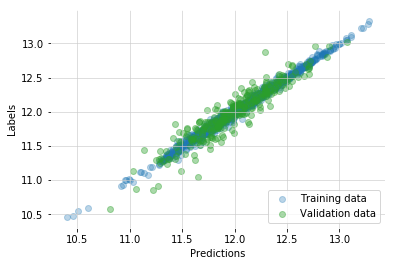

In [292]:
makeplot(lasso_stack_preds, lasso_stack_preds_test, y_train, y_test)

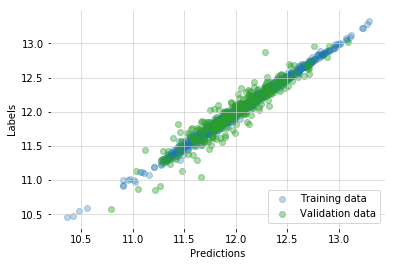

In [293]:
makeplot(ridge_stack_preds, ridge_stack_preds_test, y_train, y_test)

Lasso picked 2 features and eliminated the other 2 features


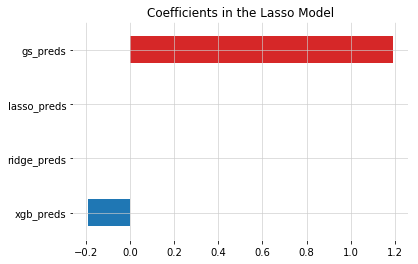

In [294]:
coefs = pd.Series(lasso_p.coef_, index = X_train_p.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(4)])
imp_coefs.plot(kind = "barh")
plt.grid(True)
plt.title("Coefficients in the Lasso Model")
plt.show()

Ridge picked 4 features and eliminated the other 0 features


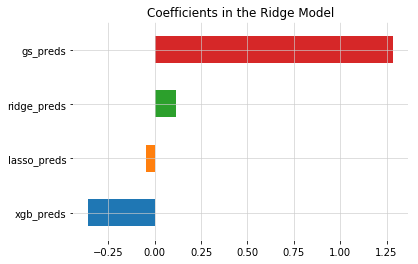

In [295]:
coefs = pd.Series(ridge_p.coef_, index = X_train_p.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(5)])
imp_coefs.plot(kind = "barh")
plt.grid(True)
plt.title("Coefficients in the Ridge Model")
plt.show()

In [296]:
#Rigde and Lasso stack results in best rmse for test, but submissions reveal that
#simple ridge and lasso perform better. Stack could be overfitting in this case...
#Prepare test set

housing_test = pd.read_csv('../data/test.csv')

In [297]:
num_model = ['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF','GrLivArea'
                , 'LotFrontage', 'LotArea','MasVnrArea', 'WoodDeckSF'
                , 'OpenPorchSF','OverallQual', 'TotRmsAbvGrd', 'ExterQual'
                , 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'
                , 'HeatingQC',  'Fireplaces', 'FireplaceQu','GarageFinish'
                , 'GarageQual', 'LotShape', 'KitchenQual','Functional']

    
cat_model = ['MSSubClass','MSZoning', 'Street', 'LandContour','LotConfig'
                    , 'Neighborhood', 'BldgType', 'HouseStyle','RoofStyle', 'MasVnrType'
                    , 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'PavedDrive'
                    ,  'MoSold', 'YrSold', 'SaleType', 'SaleCondition' 
                    , 'Exterior1st','Exterior2nd','Alley','GarageType','Fence']



special_model = ['Utilities','Condition1', 'Condition2', 'RoofMatl'
                 , 'LowQualFinSF', 'GarageArea','GarageCars'
                ,'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

added_cols = []

In [298]:
#repeating these steps is really annoying. Needs a rewrite.

df_train_tr = housing.copy()
df_test_tr = housing_test.copy()

added_cols = []
df_train_tr = remove_outliers(df_train_tr)
df_train_tr, num, add = preprocess_features(df_train_tr, num_model, added_cols, combine_garage=True)

final_num = num.copy()
final_cat = cat_model.copy()
final_added = add.copy()

df_test_tr, _, _ = preprocess_features(df_test_tr, num_model, added_cols, combine_garage=True)

df_train_tr_label = df_train_tr.pop('SalePrice')

final_df, final_test_df = process_features(df_train_tr, df_test_tr, final_num,
                            final_cat, final_added, drop=True, add_poly=True)

fixed_test = fix_columns(final_test_df.copy(), final_df.columns.values.tolist() )

final_df_label = df_train_tr_label.reset_index(drop=True).copy()

best = corr.nlargest(234, 'SalePrice').index.tolist()
best.remove("SalePrice")
X_train = final_df[best].copy()
X_test = fixed_test[best].copy()


64 skewed numerical features to log transform
extra columns: {'SaleType_CWD', 'MSSubClass_150'}


In [299]:
y_train = final_df_label.copy()
y_test = final_test_df_label.copy()

In [300]:
ridge_2 = Ridge()
params = {  
    "alpha": st.uniform(0.001, 40),
}
ridge_op = RandomizedSearchCV(ridge_2, params, n_jobs=1)  
ridge_op.fit(X_train, y_train)  
ridge_op.best_params_ 

{'alpha': 13.361717945247703}

In [301]:
#train on the whole data set
ridge = Ridge(alpha = 13.361717)
ridge.fit(X_train, y_train)  
ridge_preds = ridge.predict(X_train)
ridge_preds_test = ridge.predict(X_test)
print("RMSE on Training set :", rmse_cv_train(ridge).mean())


RMSE on Training set : 0.1170266387091157


In [302]:
housing_test.Id.head()

0    1461
1    1462
2    1463
3    1464
4    1465
Name: Id, dtype: int64

In [303]:
ridge_test = ridge.predict(X_test)

In [304]:
submission = pd.DataFrame({'Id':housing_test.Id, 'SalePrice': np.exp(ridge_test)})

In [305]:
submission.head()

,Id,SalePrice
0,1461,114420.167690
1,1462,160256.729320
2,1463,176702.831648
3,1464,187196.553922
4,1465,199108.645861


In [306]:
submission.to_csv('ridge_submit_full.csv', index=False)